In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pycaret.time_series import *

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data/petr_brent.csv
data/per-capita-energy-use.csv
data/oil-share-energy.csv
data/fossil-fuel-primary-energy.csv
data/fossil-fuel-consumption-by-type.csv
data/oil-production-by-country.csv
data/change-energy-consumption.csv
data/share-electricity-fossil-fuels.csv


In [2]:
data = pd.read_csv("data/petr_brent.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   int64  
 4   MONTH        7600 non-null   int64  
 5   YEAR         7600 non-null   int64  
 6   VALUE (US$)  7459 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 415.8+ KB


In [3]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   float64
 4   MONTH        7600 non-null   float64
 5   YEAR         7600 non-null   float64
 6   VALUE (US$)  8169 non-null   float64
dtypes: float64(4), object(3)
memory usage: 510.6+ KB


In [4]:
data.drop(["DATE", "CODE", "RAW DATE"], axis=1, inplace=True)
data.head()


DAY  MONTH    YEAR  VALUE (US$)
DATE                                       
2002-01-01  1.0    1.0  2002.0        20.13
2002-01-02  2.0    1.0  2002.0        20.13
2002-01-03  3.0    1.0  2002.0        20.47
2002-01-04  4.0    1.0  2002.0        21.20
2002-01-05  5.0    1.0  2002.0        21.16

<Axes: title={'center': 'Preço Petróleo tipo Brent'}, xlabel='DATE'>

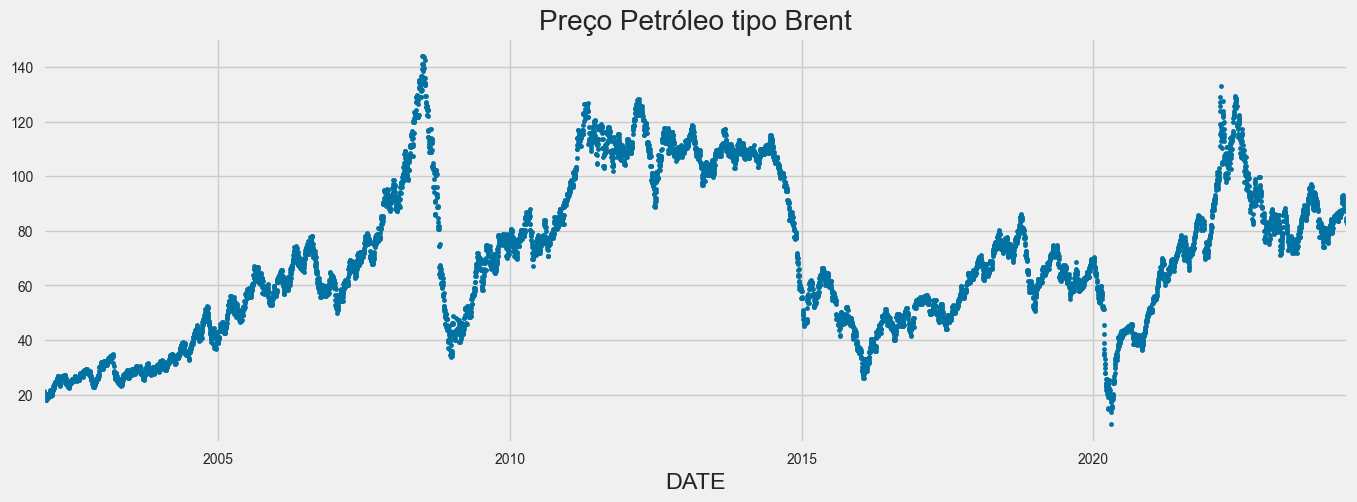

In [5]:
# df.plot(style='.', figsize=(15,5), color=color_pal[0], title = "PJME Energy Use in Mega walt (MW)");
data["VALUE (US$)"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Preço Petróleo tipo Brent"
)


In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df = create_features(data)


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAY          7600 non-null   float64
 1   MONTH        7600 non-null   float64
 2   YEAR         7600 non-null   float64
 3   VALUE (US$)  8169 non-null   float64
 4   hour         8169 non-null   int32  
 5   dayofweek    8169 non-null   int32  
 6   quarter      8169 non-null   int32  
 7   month        8169 non-null   int32  
 8   year         8169 non-null   int32  
 9   dayofyear    8169 non-null   int32  
dtypes: float64(4), int32(6)
memory usage: 510.6 KB


In [8]:
df.drop(["DAY", "MONTH", "YEAR"], axis=1, inplace=True)
df.head()


VALUE (US$)  hour  dayofweek  quarter  month  year  dayofyear
DATE                                                                     
2002-01-01        20.13     0          1        1      1  2002          1
2002-01-02        20.13     0          2        1      1  2002          2
2002-01-03        20.47     0          3        1      1  2002          3
2002-01-04        21.20     0          4        1      1  2002          4
2002-01-05        21.16     0          5        1      1  2002          5

In [9]:
df = df.loc["2018-01-01":]
fh = int(len(df) * 0.10)


# Experimento com o modelo univariado

In [10]:
df_uni = df["VALUE (US$)"]


In [11]:
experiment_uni = TSForecastingExperiment()
experiment_uni.setup(
    data=df_uni,
    target="VALUE (US$)",
    fh=fh,
    fold=4,
    use_gpu=True,
    # scale_target="minmax",
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

In [12]:
experiment_uni.plot_model()


In [13]:
experiment_uni.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


In [14]:
experiment_uni.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


In [15]:
experiment_uni.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 16]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [16]:
experiment_uni.plot_model(
    plot="train_test_split", fig_kwargs={"height": 400, "width": 900}
)


In [17]:
experiment_uni.plot_model(plot="decomp_stl", fig_kwargs={"height": 400, "width": 900})


In [18]:
experiment_uni.check_stats()


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   2325.0  
1                                      0.0  
2                                72.605204  
3                                  73.1525  
4                                19.767979  
5                               390.773012  
6                                 0.714218  
7                                  -0.0682  
8                                   1950.0  
9   {'alpha': 0.05, 'K': 24}  52264.990111  
10  {'alpha': 0.05, 'K': 48}  96816.732107  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}           0.0  
14  {'alpha': 0.05, 'K': 48}           0.0  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.378874  
17           {'alpha': 0.05}     -1.803201  
18           {'alpha': 0.05}     -3.433188  
19           {'alpha': 0.05}     -2.862794  
20           {'alpha': 0.05}     -2.567437  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}       0.75531  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

In [19]:
experiment_uni.models()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


Name  \
ID                                                                   
naive                                             Naive Forecaster   
grand_means                                 Grand Means Forecaster   
snaive                                   Seasonal Naive Forecaster   
polytrend                              Polynomial Trend Forecaster   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
exp_smooth                                   Exponential Smoothing   
ets                                                            ETS   
theta                                             Theta Forecaster   
stlf                                                          STLF   
croston                                                    Croston   
bats                                                          BATS   
tbats                                                        TBATS   
prophet                                                    Prophet   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   

                                                         Reference  Turbo  
ID                                                                         
naive                     sktime.forecasting.naive.NaiveForecaster   True  
grand_means               sktime.forecasting.naive.NaiveForecaster   True  
snaive                    sktime.forecasting.naive.NaiveForecaster   True  
polytrend        sktime.forecasting.trend._polynomial_trend_for...   True  
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
exp_smooth       sktime.forecasting.exp_smoothing.ExponentialSm...   True  
ets                                 sktime.forecasting.ets.AutoETS   True  
theta                     sktime.forecasting.theta.ThetaForecaster   True  
stlf             sktime.forecasting.trend._stl_forecaster.STLFo...   True  
croston                         sktime.forecasting.croston.Croston   True  
bats                                  sktime.forecasting.bats.BATS  False  
tbats                               sktime.forecasting.tbats.TBATS  False  
prophet          pycaret.containers.models.time_series.ProphetP...  False  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
omp_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
knn_cds_dt       pycaret.containers.models.time_series.BaseCdsD... 

In [42]:
include = [
    "ridge_cds_dt",
    "arima",
    "huber_cds_dt",
    "lightgbm_cds_dt",
    "knn_cds_dt",
    "gbr_cds_dt",
    "br_cds_dt",
    "dt_cds_dt",
    "rf_cds_dt",
    "ada_cds_dt",
    "prophet",
    "omp_cds_dt",
    "ets",
    "en_cds_dt",
    "huber_cds_dt",
    "lr_cds_dt",
    "lasso_cds_dt",
    "polytrend",
]
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt", "huber_cds_dt"]


In [61]:
metric = "mape"
best = experiment_uni.compare_models(
    n_select=8,
    include=include,
    # exclude=exclude,
    sort=metric,
    turbo=True,
)


KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

In [62]:
compare_metrics = experiment_uni.pull()


In [63]:
compare_metrics


Model    MASE  \
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending  2.8377   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  2.9356   
arima                                                        ARIMA  2.9628   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending  3.0477   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   3.091   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending  3.6087   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending  3.7321   
prophet                                                    Prophet  3.4597   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  3.7651   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  3.7651   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending  3.6917   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...  3.9068   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending  3.9158   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending  3.9158   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  3.9182   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending  3.7033   
ets                                                            ETS  3.7269   
polytrend                              Polynomial Trend Forecaster  5.4198   

                  RMSSE      MAE     RMSE    MAPE   SMAPE       R2  TT (Sec)  
rf_cds_dt        2.4532  13.8612  16.4231  0.1535  0.1513  -1.6358    5.3700  
gbr_cds_dt       2.5207  14.3735  16.9041  0.1588  0.1551  -1.8044    2.4950  
arima            2.4886  14.7413  16.9175  0.1632  0.1481  -2.1554    0.3675  
ada_cds_dt       2.6124  14.9079  17.5084  0.1649  0.1625  -2.1015    2.3600  
lightgbm_cds_dt  2.6478  15.1464  17.7819   0.169  0.1648  -2.2554    2.1775  
en_cds_dt         3.097  17.3283  20.4591  0.1934   0.212  -4.5162    2.0200  
lasso_cds_dt     3.2004  17.7332  20.9701  0.1983  0.2301  -5.6911    2.0625  
prophet          2.8883  17.5337  19.9543  0.2059  0.1769  -4.8474    0.3525  
huber_cds_dt     3.2378  18.1933  21.5198  0.2062  0.2209  -5.1572    2.1100  
huber_cds_dt     3.2378  18.1933  21.5198  0.2062  0.2209  -5.1572    2.1200  
knn_cds_dt       3.1019  18.3544  21.0485  0.2065  0.1935   -3.981    2.3200  
omp_cds_dt       3.3419  18.5585  21.8961  0.2079  0.2444  -6.5853    1.9975  
ridge_cds_dt     3.3514  18.6189  21.9752  0.2085  0.2438  -6.4942    2.0925  
lr_cds_dt        3.3514  18.6187  21.9752  0.2085  0.2438  -6.4948    2.0000  
br_cds_dt        3.3529  18.6339  21.9881  0.2087  0.2438  -6.4852    2.2600  
dt_cds_dt        3.1519  18.4591  21.4227  0.2094  0.1962  -4.9148    1.9275  
ets              3.1012  18.1825  20.8151  0.2107  0.1907  -5.3604    0.4625  
polytrend        4.2879  25.6813  28.1472  0.2897  0.3635 -10.7254    0.0075

In [64]:
compare_metrics.to_csv("compare_metrics_uni.csv")


In [65]:
experiment_uni.plot_model(best, plot="forecast")


In [57]:
prophet_model = experiment_uni.create_model("prophet")


In [58]:
experiment_uni.plot_model(prophet_model)


In [59]:
# acrescenta o modelo prophet
# best.append(prophet_model)
# best


[BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [22, 21,
                                                                         20, 19,
                                                                         18, 17,
                                                                         16, 15,
                                                                         14, 13,
                                                                         12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=RandomForestRegressor(n_jobs=-1, random_state=4395),
                     sp=22, window_length

In [66]:
# tunning
best_tuned_models = [experiment_uni.tune_model(model) for model in best]


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   43.4s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   23.5s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   56.0s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightG

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1143, number of used features: 22
[LightGBM] [Warning] No further splits with po

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   47.3s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   31.4s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   29.5s finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.7s finished


In [68]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:8][metric.upper()]
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics / top_model_metrics.sum()
display(top_model_weights)


rf_cds_dt          0.1535
gbr_cds_dt         0.1588
arima              0.1632
ada_cds_dt         0.1649
lightgbm_cds_dt     0.169
en_cds_dt          0.1934
lasso_cds_dt       0.1983
prophet            0.2059
Name: MAPE, dtype: object

rf_cds_dt          0.890903
gbr_cds_dt         0.887136
arima              0.884009
ada_cds_dt           0.8828
lightgbm_cds_dt    0.879886
en_cds_dt          0.862544
lasso_cds_dt       0.859062
prophet             0.85366
Name: MAPE, dtype: object

In [70]:
blender = experiment_uni.blend_models(
    best_tuned_models,
    method="mean",
    optimize="MAPE",
    weights=top_model_weights.values.tolist(),
)


In [71]:
y_predict = experiment_uni.predict_model(blender)
y_predict


y_pred
2023-09-25  91.4594
2023-09-26  91.3322
2023-09-27  91.1717
2023-09-28  91.1173
2023-09-29  91.0111
...             ...
2024-05-09  89.4492
2024-05-10  89.5058
2024-05-11  89.4749
2024-05-12  89.4084
2024-05-13  89.5967

[232 rows x 1 columns]

In [72]:
experiment_uni.plot_model(estimator=blender)


In [73]:
final_model = experiment_uni.finalize_model(blender)
print(experiment_uni.predict_model(final_model, fh=90))
experiment_uni.plot_model(final_model)


             y_pred
2024-05-14  83.7443
2024-05-15  83.7011
2024-05-16  83.7154
2024-05-17  83.7644
2024-05-18  83.7893
...             ...
2024-08-07  86.1390
2024-08-08  86.0576
2024-08-09  86.2439
2024-08-10  86.1551
2024-08-11  86.0213

[90 rows x 1 columns]


In [74]:
_ = experiment_uni.save_model(final_model, "petr_blender_model_uni")


Transformation Pipeline and Model Successfully Saved


In [75]:
# Load saved model
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("petr_blender_model_uni")
# m = loaded_exp.load_experiment("petr_blender_model", preprocess_data = False)
# Predictions should be same as before the model was saved and loaded
# loaded_exp.setup(scale_target='maxabs'
loaded_data = loaded_exp.predict_model(m)


Transformation Pipeline and Model Successfully Loaded


In [76]:
loaded_data


y_pred
2024-05-14  83.7443
2024-05-15  83.7011
2024-05-16  83.7154
2024-05-17  83.7644
2024-05-18  83.7893
...             ...
2024-12-27  87.5670
2024-12-28  87.6103
2024-12-29  87.7039
2024-12-30  87.5600
2024-12-31  87.6089

[232 rows x 1 columns]

In [78]:
loaded_exp.setup(data=loaded_data, use_gpu=True)
loaded_exp.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with